<a href="https://colab.research.google.com/github/shima2920/Kaggle/blob/main/New_York_City_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

from google.colab import files
files.upload()
#Kaggle account で発行した API token key ファイルを Upload する。

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list


Saving kaggle.json to kaggle.json
ref                                                       title                                         size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           3822  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    8MB  2021-02-26 11:18:15           1860  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            367  
aagghh/crypto-telegram-groups                             Crypto telegram groups                       297MB  2021-02-02 09:58:25            223  
timoboz/superbowl-history-1967-2020                       Superbowl History 1967 - 2

In [2]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 49.9MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 495kB/s]
 99% 1.55G/1.56G [00:20<00:00, 94.0MB/s]
100% 1.56G/1.56G [00:20<00:00, 82.4MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 133MB/s]


# This is Kaggle Competition "New York City Taxi Fare Prediction"

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

## **Update** 

**02/26/2021**

 

**drop longtitude, latitude and create the distance.And, remove the outlier over 99.5% data.**

The rmse of prediction is: 4.244904591114432

**Remove the outlier over 95.0% data**.

The rmse of prediction is: 3.0105892906116125

But, 5.35489 Public score on LeaderBoard.

**Remove the outlier on passenger_count column**

The rmse of prediction is: 4.216629707647034

4.09802 on LeaderBoard.

**Deep learning**

4.51722 on LeaderBoard.




# Import library

In [3]:
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

# Import data

Train data set is huge, so import just a part of train data.

In [4]:
train = pd.read_csv('train.csv.zip', nrows = 6000000)

In [5]:
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

**Data description**

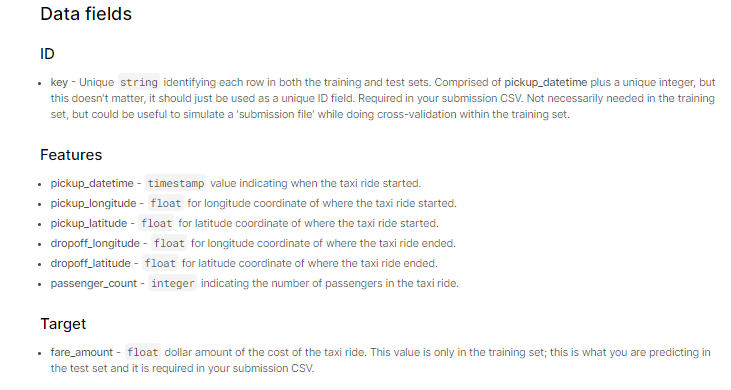

In [6]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [8]:
sample_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [9]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (6000000, 8)
Testing Features shape:  (9914, 7)


# Check missing value

In [10]:
#train
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(434)

,Total,Percent
dropoff_latitude,39,0.00065
dropoff_longitude,39,0.00065
passenger_count,0,0.00000
pickup_latitude,0,0.00000
pickup_longitude,0,0.00000
pickup_datetime,0,0.00000
fare_amount,0,0.00000
key,0,0.00000


There are 10 missing values, need to remove these rows.

In [11]:
train = train.dropna(how='any')

In [12]:
train.shape

(5999961, 8)

In [13]:
#Test
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(100)

,Total,Percent
passenger_count,0,0.0
dropoff_latitude,0,0.0
dropoff_longitude,0,0.0
pickup_latitude,0,0.0
pickup_longitude,0,0.0
pickup_datetime,0,0.0
key,0,0.0


There are no missing value in both of train and test data.

# Check data summary

In [14]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

resumetable(train)[:25]

Dataset Shape: (5999961, 8)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,key,object,0,5999961,2009-06-15 17:26:21.0000001,2010-01-05 16:52:16.0000002,2011-08-18 00:35:00.00000049,22.52
1,fare_amount,float64,0,4339,4.5,16.9,5.7,6.45
2,pickup_datetime,object,0,4281413,2009-06-15 17:26:21 UTC,2010-01-05 16:52:16 UTC,2011-08-18 00:35:00 UTC,21.78
3,pickup_longitude,float64,0,181855,-73.8443,-74.016,-73.9827,16.02
4,pickup_latitude,float64,0,216211,40.7213,40.7113,40.7613,16.40
5,dropoff_longitude,float64,0,234752,-73.8416,-73.9793,-73.9912,16.21
6,dropoff_latitude,float64,0,281453,40.7123,40.782,40.7506,16.63
7,passenger_count,int64,0,12,1,1,2,1.51


In [15]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.999961e+06,5.999961e+06,5.999961e+06,5.999961e+06,5.999961e+06,5.999961e+06
mean,1.134044e+01,-7.251148e+01,3.992409e+01,-7.251060e+01,3.992049e+01,1.684656e+00
std,9.810895e+00,1.280223e+01,9.022769e+00,1.285400e+01,9.367604e+00,1.327791e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398182e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.344459e+03,3.457622e+03,3.345917e+03,2.080000e+02


There are minus value in fare_amount, so need to remove minus values.

In [16]:
train = train[train['fare_amount'] > 0 ]
train.reset_index(drop=True).head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [17]:
train.shape

(5999539, 8)

Also, there are some incorrect value on passenger_count like 0, 200.

So, need to remove these outlier over 7 and under 1.

In [18]:
train = train[train['passenger_count'] > 0 ]
train = train[train['passenger_count'] < 7 ]
train.reset_index(drop=True).head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [19]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.978354e+06,5.978354e+06,5.978354e+06,5.978354e+06,5.978354e+06,5.978354e+06
mean,1.134982e+01,-7.251113e+01,3.992382e+01,-7.251046e+01,3.992051e+01,1.690349e+00
std,9.818846e+00,1.281132e+01,9.033023e+00,1.283578e+01,9.378077e+00,1.306225e+00
min,1.000000e-02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,1.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398182e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076711e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.344459e+03,3.457622e+03,3.345917e+03,6.000000e+00


In [20]:
train.shape

(5978354, 8)

In [21]:
resumetable(test)[:25]

Dataset Shape: (9914, 7)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,key,object,0,9914,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24.0000003,2011-10-08 11:53:44.0000002,13.28
1,pickup_datetime,object,0,1753,2015-01-27 13:08:24 UTC,2015-01-27 13:08:24 UTC,2011-10-08 11:53:44 UTC,8.87
2,pickup_longitude,float64,0,9125,-73.9733,-73.9869,-73.9825,13.11
3,pickup_latitude,float64,0,9247,40.7638,40.7194,40.7513,13.14
4,dropoff_longitude,float64,0,9142,-73.9814,-73.9989,-73.9797,13.11
5,dropoff_latitude,float64,0,9360,40.7438,40.7392,40.7461,13.16
6,passenger_count,int64,0,6,1,1,1,1.46


In [22]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


# EDA

Let's see the fare distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


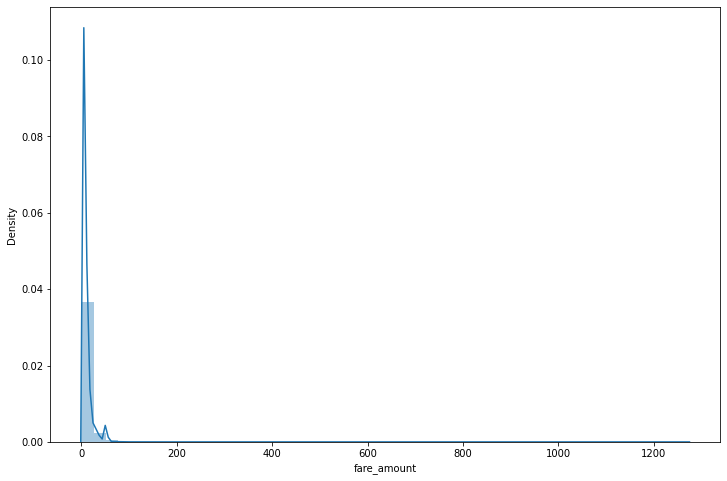

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure(figsize=(12,8))
sns.distplot( train['fare_amount'],  bins=50, kde=True);
fig = plt.figure()

Therea re some outlier, so need to remove these value.

In [24]:
###上位〇〇%, 下位△△%をulimit/llimitの値に置き換える(外れ値の除去)####################################
for col in ["fare_amount"]:
    ulimit = np.percentile(train[col].values, 99.5)
    llimit = np.percentile(train[col].values, 0.5)
    train[col].iloc[train[col]>ulimit] = ulimit
    train[col].iloc[train[col]<llimit] = llimit

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [25]:
train.shape

(5978354, 8)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


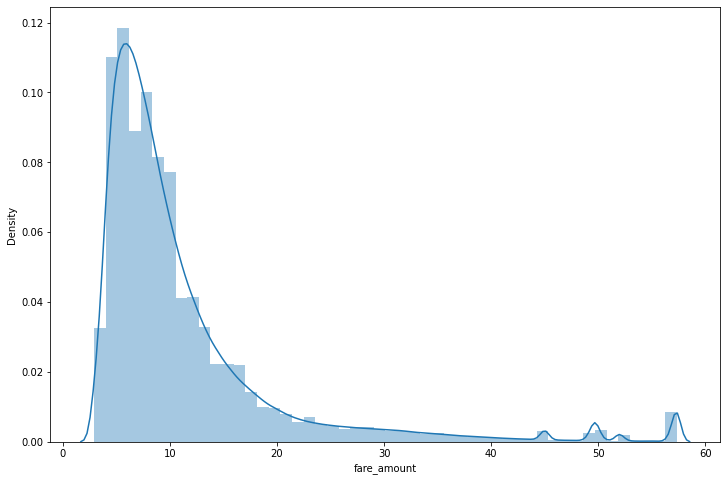

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figsize=(12,8))
sns.distplot( train['fare_amount'],  bins=50, kde=True);
fig = plt.figure()

# Preprocessing for key and datetime.

Firstly, it seems key value fields are not needed, bacause these value is just ID and timestamp that is included in other variables.

In [27]:
train = train.drop(['key'], axis = 1)
test = test.drop(['key'], axis = 1)

In [28]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Split the pickup_datetime into Year, Month, Hour. Day, minute, seconds seems no relation with target value, so we can ignore.

Year, Month : Fare would be changed based on the season.

weekday : Its also can be changed

hour : midnight fare would be exist.

In [29]:
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])
train["Year"] = train["pickup_datetime"].apply(lambda x:x.year)
train["Month"] = train["pickup_datetime"].apply(lambda x:x.month)
train['weekday'] = train["pickup_datetime"].apply(lambda t: t.weekday())
train["hour"] = train["pickup_datetime"].apply(lambda x:x.hour)
train = train.drop(['pickup_datetime'], axis = 1)

In [30]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,weekday,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,7


In [31]:
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"])
test["Year"] = test["pickup_datetime"].apply(lambda x:x.year)
test["Month"] = test["pickup_datetime"].apply(lambda x:x.month)
test['weekday'] = test["pickup_datetime"].apply(lambda t: t.weekday())
test["hour"] = test["pickup_datetime"].apply(lambda x:x.hour)
test = test.drop(['pickup_datetime'], axis = 1)

In [32]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,weekday,hour
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21


# EDA

Lets see the relationship between target value and other variables.

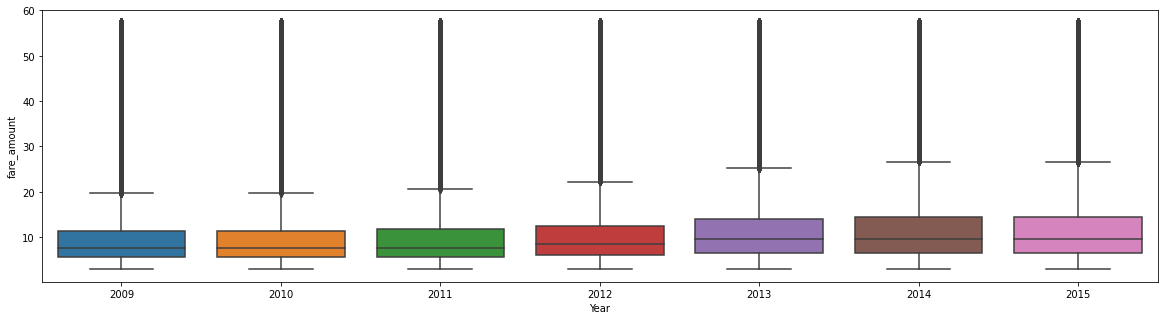

In [33]:
import seaborn as sn
fig1,ax1 = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="Year",y="fare_amount",orient="v",ax=ax1)

Fare are getting a bit increased year to year.

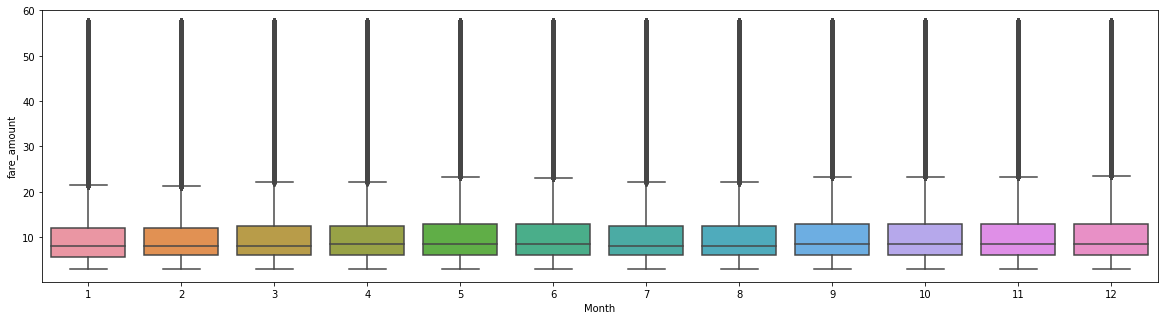

In [34]:
fig1,ax1 = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="Month",y="fare_amount",orient="v",ax=ax1)

Fare is the same through year.

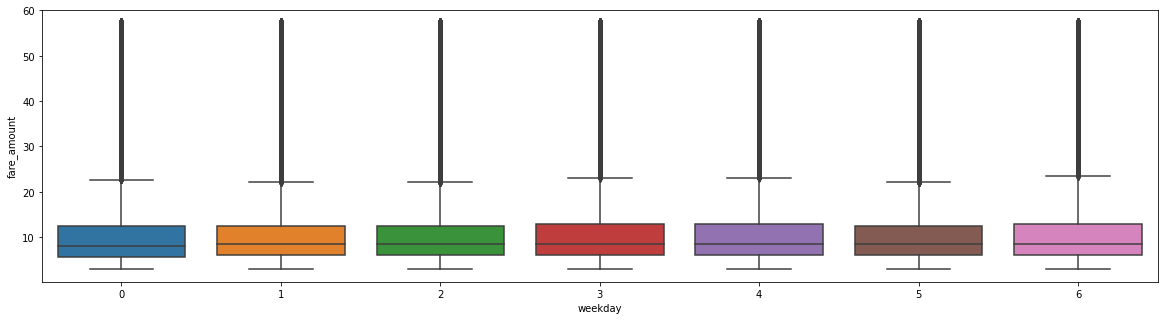

In [35]:
fig1,ax1 = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="weekday",y="fare_amount",orient="v",ax=ax1)

Fare is the same through week.

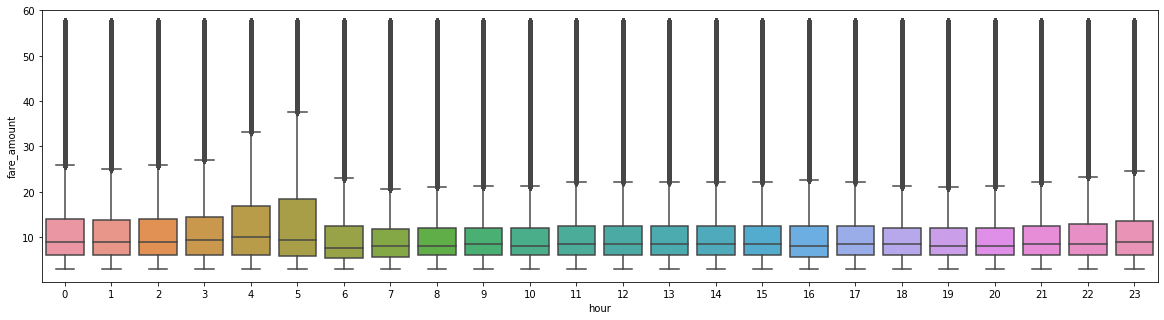

In [36]:
fig1,ax1 = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="hour",y="fare_amount",orient="v",ax=ax1)

Fare is higher in midnight.

# Preprocessing for longtitude, latitude.

We can create distance variable from pickup/dropoff longtitude and latitiude.

In [37]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

In [38]:
# add new column to dataframe with distance in miles
train['distance_miles'] = distance(train.pickup_latitude, train.pickup_longitude, train.dropoff_latitude, train.dropoff_longitude)

In [39]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,weekday,hour,distance_miles
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,17,0.640487
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,16,5.250670
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,0,0.863411
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,4,1.739386
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,7,1.242218


In [40]:
# add new column to dataframe with distance in miles
test['distance_miles'] = distance(test.pickup_latitude, test.pickup_longitude, test.dropoff_latitude, test.dropoff_longitude)

In [41]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,weekday,hour,distance_miles
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,1.443607
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,1.507044
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,0.384398
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,1.218529
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,3.347514


It seems the latitude and longtitude columns are no more needed, because, we could calculate the distance based on these values.

So, dorp these columns.

In [42]:
train=train.drop(['pickup_longitude'],axis=1)
train=train.drop(['pickup_latitude'],axis=1)
train=train.drop(['dropoff_longitude'],axis=1)
train=train.drop(['dropoff_latitude'],axis=1)

In [43]:
test=test.drop(['pickup_longitude'],axis=1)
test=test.drop(['pickup_latitude'],axis=1)
test=test.drop(['dropoff_longitude'],axis=1)
test=test.drop(['dropoff_latitude'],axis=1)

In [44]:
train.head()

,fare_amount,passenger_count,Year,Month,weekday,hour,distance_miles
0,4.5,1,2009,6,0,17,0.640487
1,16.9,1,2010,1,1,16,5.250670
2,5.7,2,2011,8,3,0,0.863411
3,7.7,1,2012,4,5,4,1.739386
4,5.3,1,2010,3,1,7,1.242218


# Modeling LightGBM with Optuna

In [45]:
'''
x_train = train.drop(['fare_amount'], axis = 1)
y_train = train['fare_amount']
'''

"\nx_train = train.drop(['fare_amount'], axis = 1)\ny_train = train['fare_amount']\n"

In [46]:
'''
# Train/validation用にデータ分割
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)
'''

'\n# Train/validation用にデータ分割\nfrom sklearn.model_selection import train_test_split\nX_train,X_test,Y_train,Y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)\n'

In [47]:
'''
#LightGBM用のデータ作成
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_test, Y_test, reference=lgb_train)
'''

'\n#LightGBM用のデータ作成\nlgb_train = lgb.Dataset(X_train, Y_train)\nlgb_valid = lgb.Dataset(X_test, Y_test, reference=lgb_train)\n'

In [48]:
'''
# to record eval results for plotting
evals_result = {} 
'''

'\n# to record eval results for plotting\nevals_result = {} \n'

In [49]:
'''
#OptunaチューニングParam
optuna_params = {
    'task': 'train',
    #'boosting_type': 'gbdt',
    'objective': 'regression',# regression(回帰), binary(二値分類, ラベルは0,1),multiclass(多クラス分類, metricとしては、multi_logloss, multi_error(正答率))
    'metric': "rmse", #regression : 絶対値誤差関数(L1)ならばmae, 2乗誤差関数(L2)ならばmseと指定, rmse
                      #binary : binary_logloss(クロスエントロピー)とbinary_error(正答率)の2つ
                      #multiclass : multi_logloss(softmax関数)とmulti_error(正答率)の2つ
    #'num_leaves': 20,#木にある分岐の個数．デフォルトは31, 大きくすると精度は上がるが過学習が進む
    #'max_depth': 10,#木構造の深さを限定するための変数．データが少ないときに過学習を防ぐために設定する．デフォルト値は-1で0以下の値は制限なしを意味する．
    #'learning_rate': 0.05,#学習率。デフォルトは0.1
    #'feature_fraction': 0.9,#学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する．
    #'min_data_in_leaf':4,#大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．
    #'verbose':50
}
'''

'\n#OptunaチューニングParam\noptuna_params = {\n    \'task\': \'train\',\n    #\'boosting_type\': \'gbdt\',\n    \'objective\': \'regression\',# regression(回帰), binary(二値分類, ラベルは0,1),multiclass(多クラス分類, metricとしては、multi_logloss, multi_error(正答率))\n    \'metric\': "rmse", #regression : 絶対値誤差関数(L1)ならばmae, 2乗誤差関数(L2)ならばmseと指定, rmse\n                      #binary : binary_logloss(クロスエントロピー)とbinary_error(正答率)の2つ\n                      #multiclass : multi_logloss(softmax関数)とmulti_error(正答率)の2つ\n    #\'num_leaves\': 20,#木にある分岐の個数．デフォルトは31, 大きくすると精度は上がるが過学習が進む\n    #\'max_depth\': 10,#木構造の深さを限定するための変数．データが少ないときに過学習を防ぐために設定する．デフォルト値は-1で0以下の値は制限なしを意味する．\n    #\'learning_rate\': 0.05,#学習率。デフォルトは0.1\n    #\'feature_fraction\': 0.9,#学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する．\n    #\'min_data_in_leaf\':4,#大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．\n    #\'verbose\':50\n}\n'

In [50]:
'''
#Optunaを用いて最適化し、LGBにTrainさせる
model = lgb.train(optuna_params,
                  lgb_train,
                  valid_sets=lgb_valid,
                  verbose_eval=0,
                  num_boost_round=1000,
                  early_stopping_rounds=50
                  )
                  '''


'\n#Optunaを用いて最適化し、LGBにTrainさせる\nmodel = lgb.train(optuna_params,\n                  lgb_train,\n                  valid_sets=lgb_valid,\n                  verbose_eval=0,\n                  num_boost_round=1000,\n                  early_stopping_rounds=50\n                  )\n                  '

In [51]:
'''
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)
'''


'\ny_pred_test = model.predict(X_test, num_iteration=model.best_iteration)\n'

In [52]:
'''
# eval rmse
print('\nThe rmse of prediction is:', mean_squared_error(Y_test, y_pred_test) ** 0.5)
accuracy = mean_squared_error(Y_test, y_pred_test) ** 0.5
'''


"\n# eval rmse\nprint('\nThe rmse of prediction is:', mean_squared_error(Y_test, y_pred_test) ** 0.5)\naccuracy = mean_squared_error(Y_test, y_pred_test) ** 0.5\n"

In [53]:
'''
best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))
    '''


'\nbest_params = model.params\nprint("Best params:", best_params)\nprint("  Accuracy = {}".format(accuracy))\nprint("  Params: ")\nfor key, value in best_params.items():\n    print("    {}: {}".format(key, value))\n    '

In [54]:
'''
y_pred = model.predict(test, num_iteration=model.best_iteration)
'''


'\ny_pred = model.predict(test, num_iteration=model.best_iteration)\n'

# Deep Learning

In [55]:
train_df, test_df = train_test_split(train, test_size=0.10, random_state=1)

In [56]:
# Get labels
train_labels = train_df['fare_amount'].values
test_labels = test_df['fare_amount'].values
train_df = train_df.drop(['fare_amount'], axis=1)
test_df = test_df.drop(['fare_amount'], axis=1)

In [57]:
# Scale data
# Note: im doing this here with sklearn scaler but, on the Coursera code the scaling is done with Dataflow and Tensorflow
scaler = preprocessing.MinMaxScaler()#0-1に正規化
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)
test_scaled = scaler.transform(test)

In [58]:
from keras import regularizers
from keras.layers import Dense, BatchNormalization, Activation
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))#activationは、特徴の学習をしやすくするために、データを整える。
#ReLuは「0より大きければそのまま、0より小さければ0に置き換えて」出力, 回帰分析
#Sigmoidは「0から1の間にマッピングしなおして」出力, 分類
model.add(BatchNormalization())# DLにおける各重みパラメータを上手くreparametrizationすることで、ネットワークを最適化するための方法の一つ。
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

In [59]:
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.001
DATASET_SIZE = 6000000

In [60]:
from keras import optimizers 
adam = optimizers.Adam(lr=LEARNING_RATE)#adamは、最適化アルゴリズム
model.compile(loss='mse', optimizer=adam, metrics=['mae'])
#mse:平均二乗誤差
#mae:平均絶対誤差

In [61]:
print('Dataset size: %s' % DATASET_SIZE)
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % train_df_scaled.shape[1])
print('Features used: %s' % train_df.columns)


Dataset size: 6000000
Epochs: 50
Learning rate: 0.001
Batch size: 256
Input dimension: 6
Features used: Index(['passenger_count', 'Year', 'Month', 'weekday', 'hour',
       'distance_miles'],
      dtype='object')


In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [63]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)
history = model.fit(x=train_df_scaled, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(test_df_scaled, test_labels), 
                    callbacks = [early_stopping],
                    shuffle=True)
#batch_sizeとは 1 回に計算するデータの数
#エポック数とは1と2の手順を何回実行
#1.データセットをバッチサイズに従ってN個のサブセットに分ける。
#2.各サブセットを学習に回す。つまり、N回学習を繰り返す。

Epoch 1/50
21018/21018 [==============================] - 111s 5ms/step - loss: 56.4348 - mae: 4.2118 - val_loss: 114.0935 - val_mae: 9.9225
Epoch 2/50
21018/21018 [==============================] - 108s 5ms/step - loss: 19.0538 - mae: 2.3885 - val_loss: 214.4445 - val_mae: 13.7041
Epoch 3/50
21018/21018 [==============================] - 106s 5ms/step - loss: 18.7785 - mae: 2.3535 - val_loss: 75.1219 - val_mae: 7.7962
Epoch 4/50
21018/21018 [==============================] - 107s 5ms/step - loss: 18.3596 - mae: 2.3180 - val_loss: 169.5312 - val_mae: 11.2521
Epoch 5/50
21018/21018 [==============================] - 107s 5ms/step - loss: 18.3176 - mae: 2.3050 - val_loss: 121.8964 - val_mae: 10.2793
Epoch 6/50
21018/21018 [==============================] - 108s 5ms/step - loss: 18.0764 - mae: 2.2876 - val_loss: 22.7359 - val_mae: 2.8365
Epoch 7/50
21018/21018 [==============================] - 107s 5ms/step - loss: 18.0380 - mae: 2.2796 - val_loss: 97.1837 - val_mae: 8.3721
Epoch 8/50
21

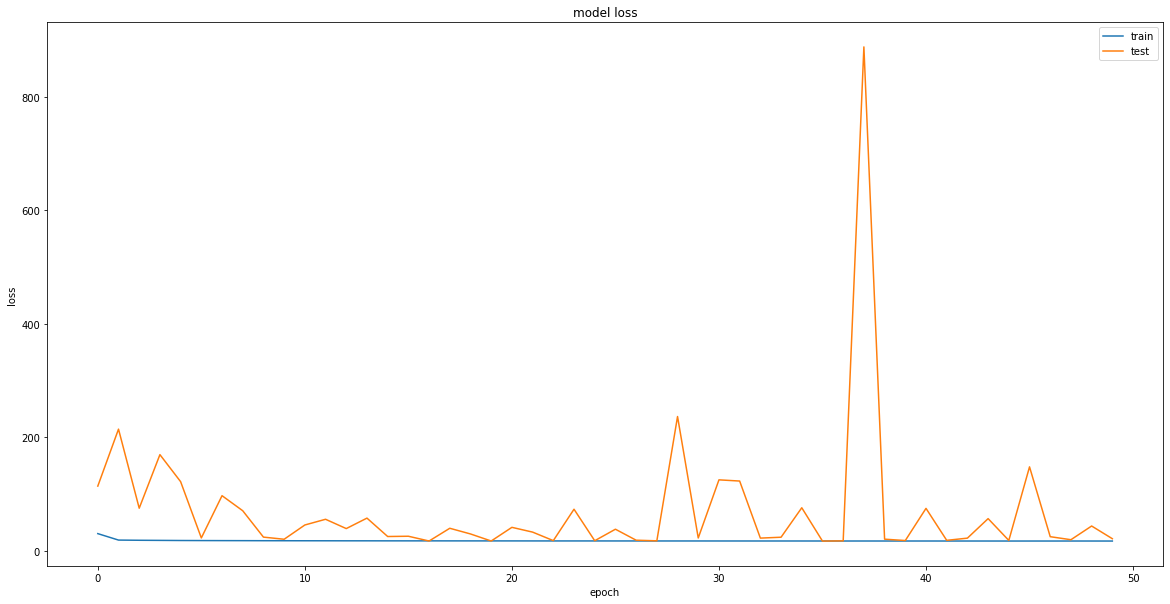

In [65]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_loss_accuracy(history)

In [66]:
# Make prediction
y_pred = model.predict(test_scaled, batch_size=128, verbose=1)

78/78 [==============================] - 0s 1ms/step


# Submit

In [67]:
#Submit方法
sub = pd.DataFrame(pd.read_csv('test.csv')['key'])
sub['fare_amount'] = list(map(int, y_pred))
sub.to_csv('submission_yshimamu.csv', index=False)

In [68]:
!kaggle competitions submit new-york-city-taxi-fare-prediction -f submission_yshimamu.csv -m "First commit"

100% 300k/300k [00:02<00:00, 113kB/s]
Successfully submitted to New York City Taxi Fare Prediction